In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.transforms import offset_copy
import pickle
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")
from CIFAR.load_cifar10 import load_data10
from SVHN.load_svhn import load_data_svhn

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Using TensorFlow backend.


### Load and/or Create Whitening Matrices

In [2]:
u_tiny = np.load('./tiny-imagenet/u.npy')
s_tiny = np.load('./tiny-imagenet/s.npy')
# v_tiny = np.load('./tiny-imagenet/v.npy')
mean_img_tiny = np.load('./tiny-imagenet/mean.npy')

In [3]:
mean_img_mnist = np.mean(mnist.train.images, axis=0)
cov = np.dot((mnist.train.images - mean_img_mnist).T, (mnist.train.images - mean_img_mnist))/mnist.train.images.shape[0]
u_mnist,s_mnist,v_mnist = np.linalg.svd(cov)

In [4]:
x, _, _, _ = load_data10()
x = x.reshape((-1,32*32*3))
mean_img_cifar = np.mean(x, axis=0)
cov = np.dot((x - mean_img_cifar).T, (x - mean_img_cifar))/x.shape[0]
u_cifar, s_cifar, v_cifar = np.linalg.svd(cov)

In [5]:
x, _, _, _ = load_data_svhn()
x = x.reshape((-1,32*32*3))
mean_img_svhn = np.mean(x, axis=0)
cov = np.dot((x - mean_img_svhn).T, (x - mean_img_svhn))/x.shape[0]
u_svhn, s_svhn, v_svhn = np.linalg.svd(cov)

### Load Adversarial Examples 

In [6]:
tiny_fast_clipped = pickle.load(open('./tiny-imagenet/data/tiny_foolers_fast/tiny_foolers_fast_clip.p', 'rb'),
                                encoding='latin1')
tiny_iter_clipped = pickle.load(open('./tiny-imagenet/data/tiny_foolers/tiny_foolers_clip.p', 'rb'),
                                encoding='latin1')
tiny_fast = pickle.load(open('./tiny-imagenet/data/tiny_foolers_fast/tiny_foolers_fast.p', 'rb'),
                                encoding='latin1')
tiny_iter = pickle.load(open('./tiny-imagenet/data/tiny_foolers/tiny_foolers_clip.p', 'rb'),
                                encoding='latin1')

tiny_fast_clipped_keys = list(tiny_fast_clipped.keys())
tiny_iter_clipped_keys = list(tiny_iter_clipped.keys())
tiny_fast_keys = list(tiny_fast.keys())
tiny_iter_keys = list(tiny_iter.keys())

mnist_iter = pickle.load(open('./MNIST/data/normal.p', 'rb'), encoding='latin1')
mnist_fast = pickle.load(open('./MNIST/data/fast.p', 'rb'), encoding='latin1')
mnist_iter_keys = list(mnist_iter.keys())
mnist_fast_keys = list(mnist_fast.keys())

cifar_iter = pickle.load(open('./CIFAR/data/normal_foolers.p', 'rb'), encoding='latin1')
cifar_fast = pickle.load(open('./CIFAR/data/fast_foolers.p', 'rb'), encoding='latin1')
cifar_iter_keys = list(cifar_iter.keys())
cifar_fast_keys = list(cifar_fast.keys())

svhn_iter = pickle.load(open('./SVHN/normal_foolers.p', 'rb'), encoding='latin1')
svhn_fast = pickle.load(open('./SVHN/fast_foolers.p', 'rb'), encoding='latin1')
svhn_iter_keys = list(svhn_iter.keys())
svhn_fast_keys = list(svhn_fast.keys())

In [7]:
def rescaler(img):
    low, high = np.min(img), np.max(img)
    return (img - low) / (high - low)

def show_tiny_whitened(image, rescale=False, add_mean=False, zca=False, smoother=1e-4):
    img = image.copy()
    img = img.transpose(1,2,0)
    
    img = img.reshape(1,64*64*3)
    img = np.dot(img, u_tiny)
    img = img/np.sqrt(s_tiny + smoother)
    if zca is True:
        img = np.dot(img, u_tiny.T)
        
    img = img.reshape((64,64,3))
    
    if add_mean:
        img += mean_img_tiny.reshape((64,64,3))
    
    if rescale:
        img = rescaler(img)

    return img

In [8]:
k = np.random.choice(tiny_fast_clipped_keys)
image_fool = tiny_fast_clipped[k][3][0]
image = tiny_fast_clipped[k][4][0]

### Create ZCA Whitened Image Graphic 

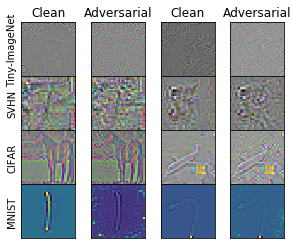

In [24]:
def turn_off_ticks():
    plt.tick_params(axis='both', which='both', bottom='off',
                top='off', labelbottom='off', right='off',
                left='off', labelleft='off')
        
with PdfPages('whitened.pdf') as pdf:
    fig = plt.figure(1, (5, 3.75))

    for i in range(1,4,2):
        k = np.random.choice(tiny_fast_clipped_keys)
        image_fool = tiny_fast_clipped[k][3][0]
        image = tiny_fast_clipped[k][4][0]

        plt.subplot(4,4,i)
        if i == 1:
            plt.ylabel('Tiny-ImageNet')
        plt.title('Clean')
        plt.imshow(show_tiny_whitened(image, rescale=True, zca=True, add_mean=False))
        turn_off_ticks()
        
        plt.subplot(4,4,i+1)
        plt.title('Adversarial')
        plt.imshow(show_tiny_whitened(image_fool, rescale=True, zca=True, add_mean=False))
        turn_off_ticks()

    for i in range(5,8,2):
        k = np.random.choice(svhn_iter_keys)
        image_fool = svhn_iter[k][3][0].reshape((1,32*32*3))
        image = svhn_iter[k][4][0].reshape((1,32*32*3))

        plt.subplot(4,4,i)
        if i == 5:
            plt.ylabel('SVHN')
        img = np.dot(image - mean_img_svhn, u_svhn)
        img = np.dot(img/np.sqrt(s_svhn + 1e-4), u_svhn.T)
        plt.imshow(rescaler(img).reshape(32,32,3))
        turn_off_ticks()
        
        plt.subplot(4,4,i+1)
        img = np.dot(image_fool - mean_img_svhn, u_svhn)
        img = np.dot(img/np.sqrt(s_svhn + 1e-4), u_svhn.T)
        plt.imshow(rescaler(img).reshape(32,32,3))
        turn_off_ticks()

        
    for i in range(9,12,2):
        k = np.random.choice(cifar_iter_keys)
        image_fool = cifar_iter[k][3][0].reshape((1,32*32*3))
        image = cifar_iter[k][4][0].reshape((1,32*32*3))

        plt.subplot(4,4,i)
        if i == 9:
            plt.ylabel('CIFAR')
        img = np.dot(image - mean_img_cifar, u_cifar)
        img = np.dot(img/np.sqrt(s_cifar + 1e-4), u_cifar.T)
        plt.imshow(rescaler(img).reshape(32,32,3))
        turn_off_ticks()
        
        plt.subplot(4,4,i+1)
        img = np.dot(image_fool - mean_img_cifar, u_cifar)
        img = np.dot(img/np.sqrt(s_cifar + 1e-4), u_cifar.T)
        plt.imshow(rescaler(img).reshape(32,32,3))
        turn_off_ticks()

    for i in range(13,17,2):
        k = np.random.choice(mnist_iter_keys)
        image_fool = mnist_iter[k][2][0]
        image = mnist_iter[k][3][0]

        plt.subplot(4,4,i)
        if i == 13:
            plt.ylabel('MNIST')
        img = np.dot(image-mean_img_mnist, u_mnist)
        img = np.dot(img/np.sqrt(s_mnist + 1e-4), u_mnist.T)
        plt.imshow(rescaler(img).reshape(28,28))
        turn_off_ticks()
        
        plt.subplot(4,4,i+1)
        img = np.dot(image_fool-mean_img_mnist, u_mnist)
        img = np.dot(img/np.sqrt(s_mnist + 1e-4), u_mnist.T)
        plt.imshow(rescaler(img).reshape(28,28))
        turn_off_ticks()

    plt.subplots_adjust(left=None, bottom=0, right=None, top=0.8, wspace=0, hspace=0)
    
    pdf.savefig(fig, bbox_inches='tight', pad_inches=0)

In [10]:
np.sum(s_tiny[:5000])/np.sum(s_tiny)

0.99921036

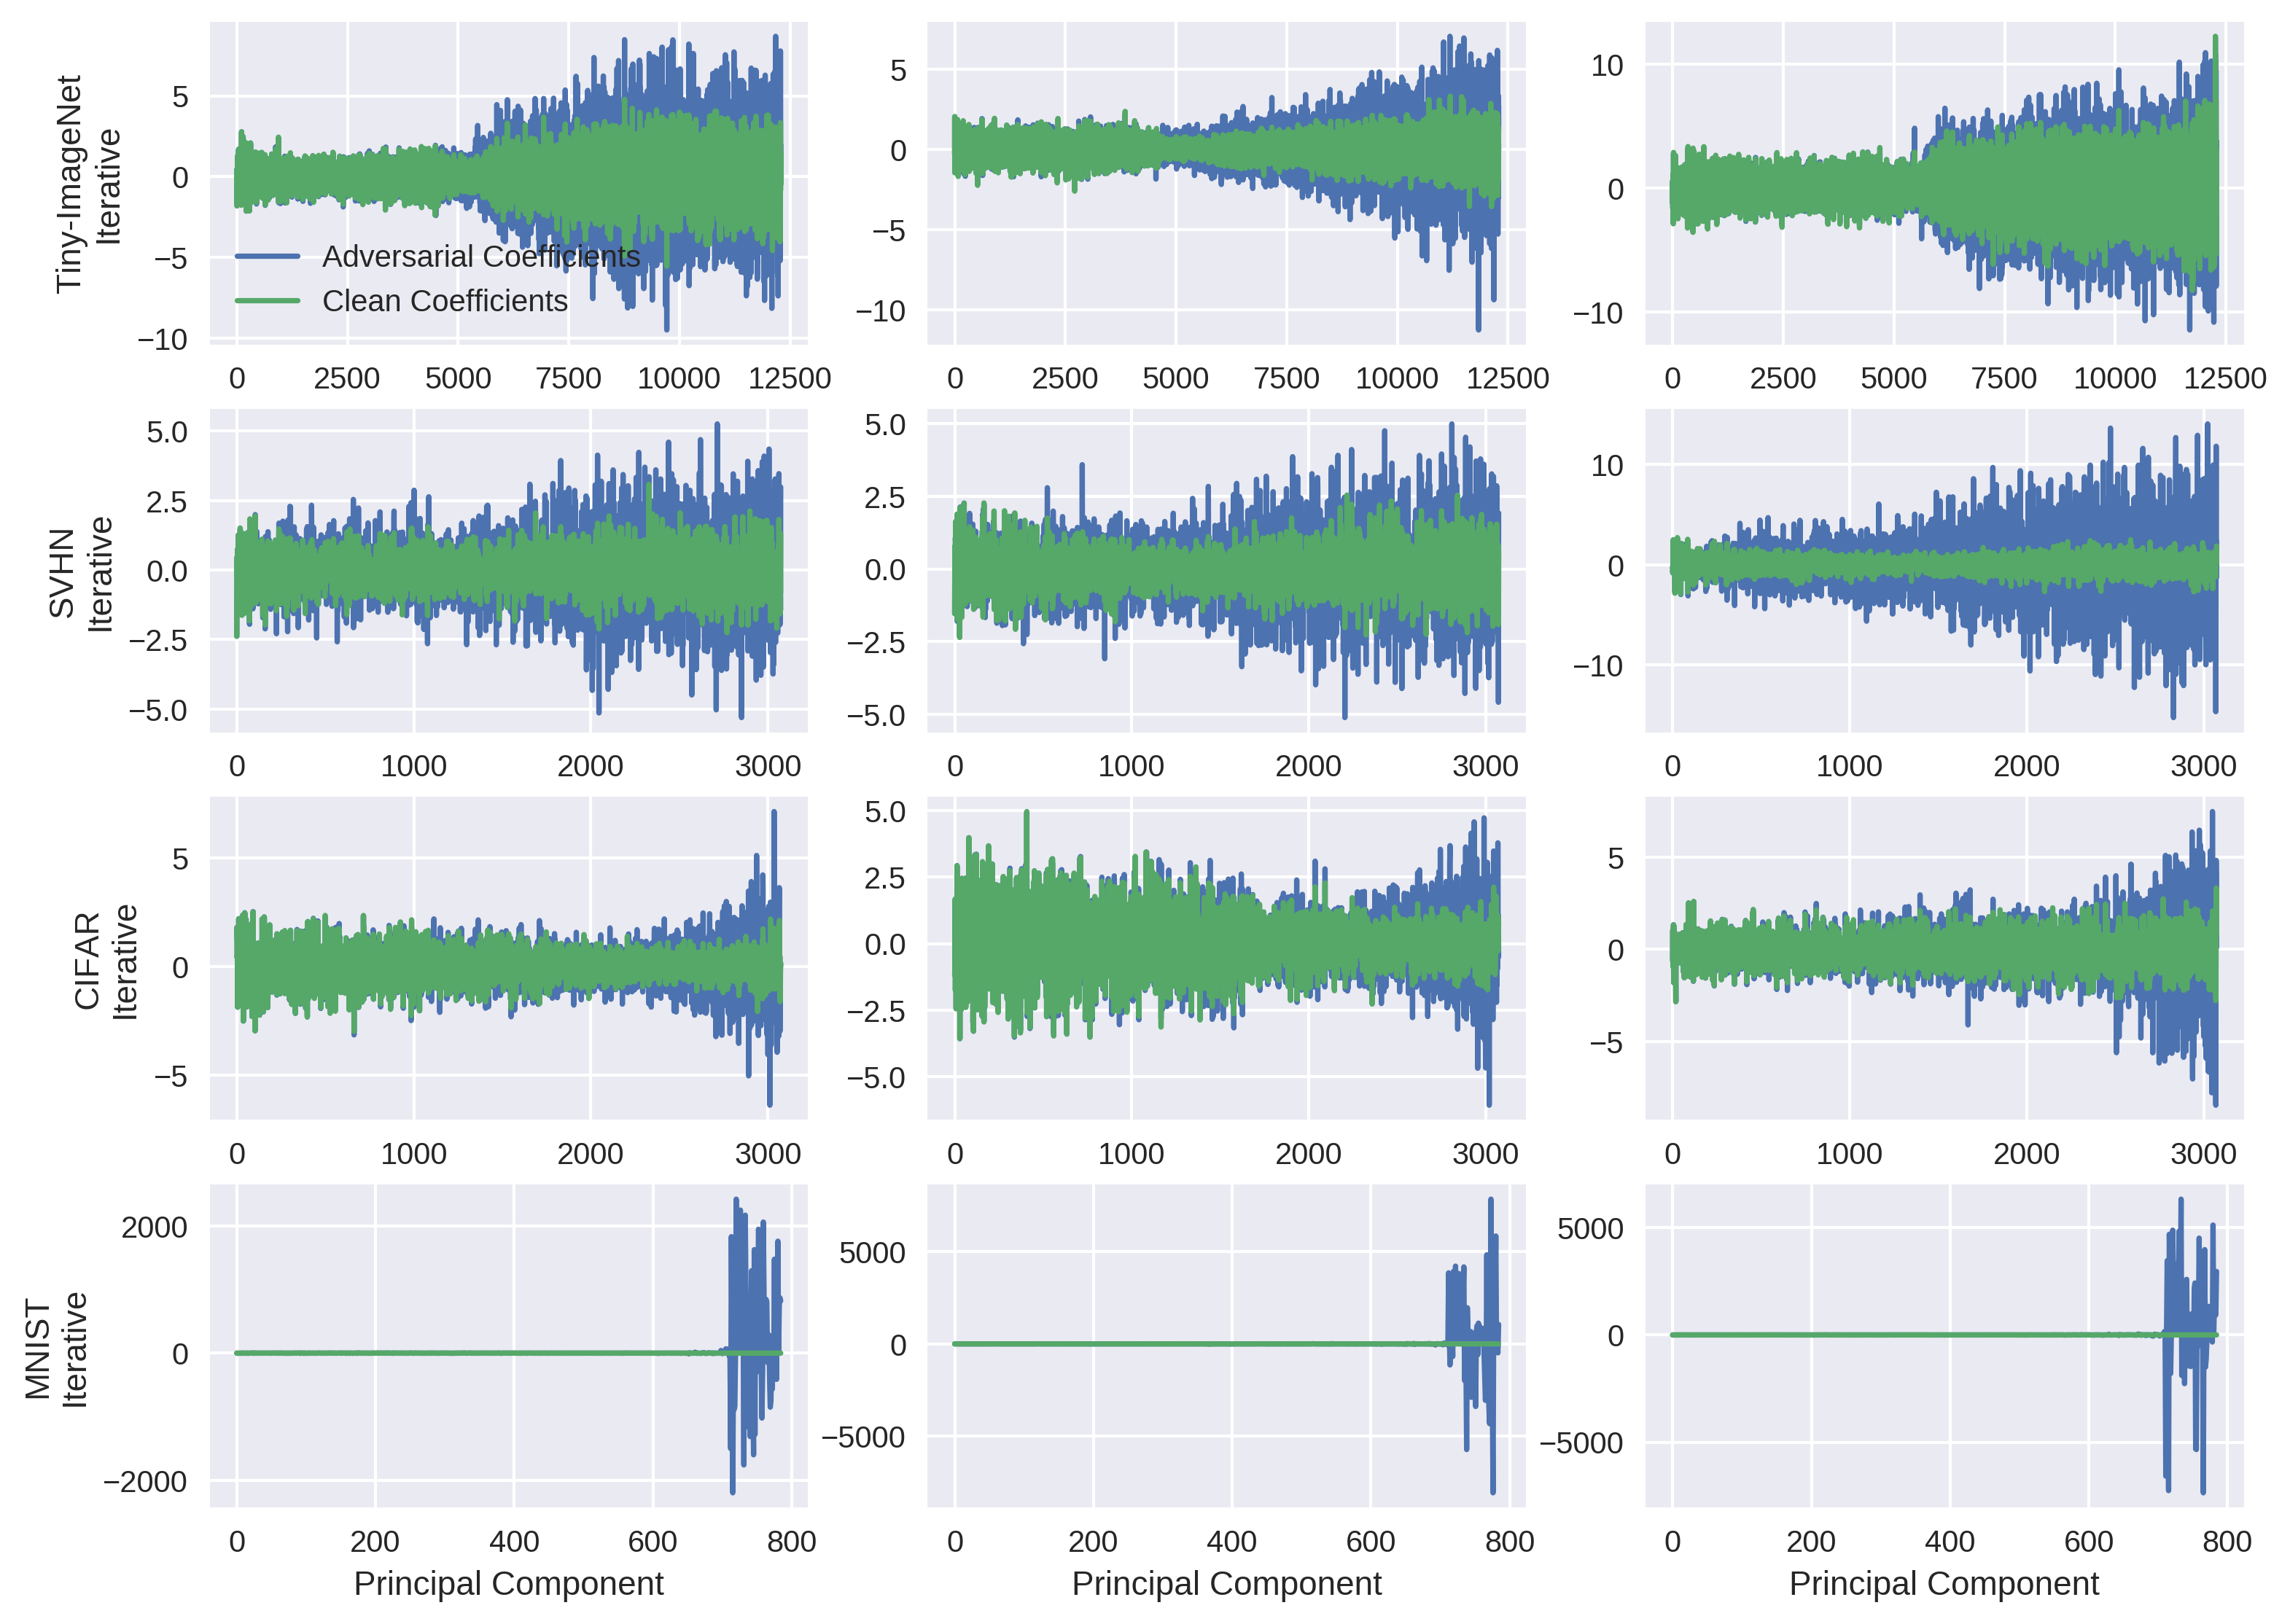

In [94]:
with PdfPages('coefficients.pdf') as pdf:
    rows = ['SVHN\nIterative', 'Tiny-ImageNet\nIterative',
           'CIFAR\nIterative', 'MNIST\nIterative']

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 9), dpi=300)

    fooler_type_number = 0
    for i in range(1,13):
        if fooler_type_number//3 == 0:
            dataset, dataset_keys = tiny_iter_clipped, tiny_iter_clipped_keys
            row_label = rows[1]
        elif fooler_type_number//3 == 1:
            dataset, dataset_keys = svhn_iter, svhn_iter_keys
            row_label = rows[0]
        elif fooler_type_number//3 == 2:
            dataset, dataset_keys = cifar_iter, cifar_iter_keys
            row_label = rows[2]
        elif fooler_type_number//3 == 3:
            dataset, dataset_keys = mnist_iter, mnist_iter_keys
            row_label = rows[3]

        k = np.random.choice(dataset_keys)
        if fooler_type_number // 3 != 3:
            image = dataset[k][4][0]
            image_fool = dataset[k][3][0]
        else:
            image = dataset[k][3][0]
            image_fool = dataset[k][2][0]

        plt.subplot(4,3,i)   
        if fooler_type_number//3 == 0:
            f = show_tiny_whitened(image_fool, smoother=1e-11).reshape((-1))
            r = show_tiny_whitened(image, smoother=1e-11).reshape((-1))
        elif fooler_type_number//3 == 1:
            img = np.dot(image_fool.reshape((-1))-mean_img_svhn, u_svhn)
            f = img/np.sqrt(s_svhn + 1e-11)
            img = np.dot(image.reshape((-1))-mean_img_svhn, u_svhn)
            r = img/np.sqrt(s_svhn + 1e-11)         
        elif fooler_type_number//3 == 2:
            img = np.dot(image_fool.reshape((-1))-mean_img_cifar, u_cifar)
            f = img/np.sqrt(s_cifar + 1e-11)
            img = np.dot(image.reshape((-1))-mean_img_cifar, u_cifar)
            r = img/np.sqrt(s_cifar + 1e-11)
        elif fooler_type_number//3 == 3:
            img = np.dot(image_fool-mean_img_mnist, u_mnist)
            f = img/np.sqrt(s_mnist + 1e-11)
            img = np.dot(image-mean_img_mnist, u_mnist)
            r = img/np.sqrt(s_mnist + 1e-11)
        
        plt.plot(np.linspace(0, len(f), len(f)), f, rasterized=True)
        plt.plot(np.linspace(0, len(r), len(r)), r, rasterized=True)

        fooler_type_number += 1    
        if fooler_type_number == 1:
            plt.legend(['Adversarial Coefficients', 'Clean Coefficients'])
        if (fooler_type_number-1) % 3 == 0:
            plt.ylabel(row_label)
        if i == 12 or i == 11 or i == 10:
            plt.xlabel('Principal Component')


    pdf.savefig(fig, bbox_inches='tight', pad_inches=0)

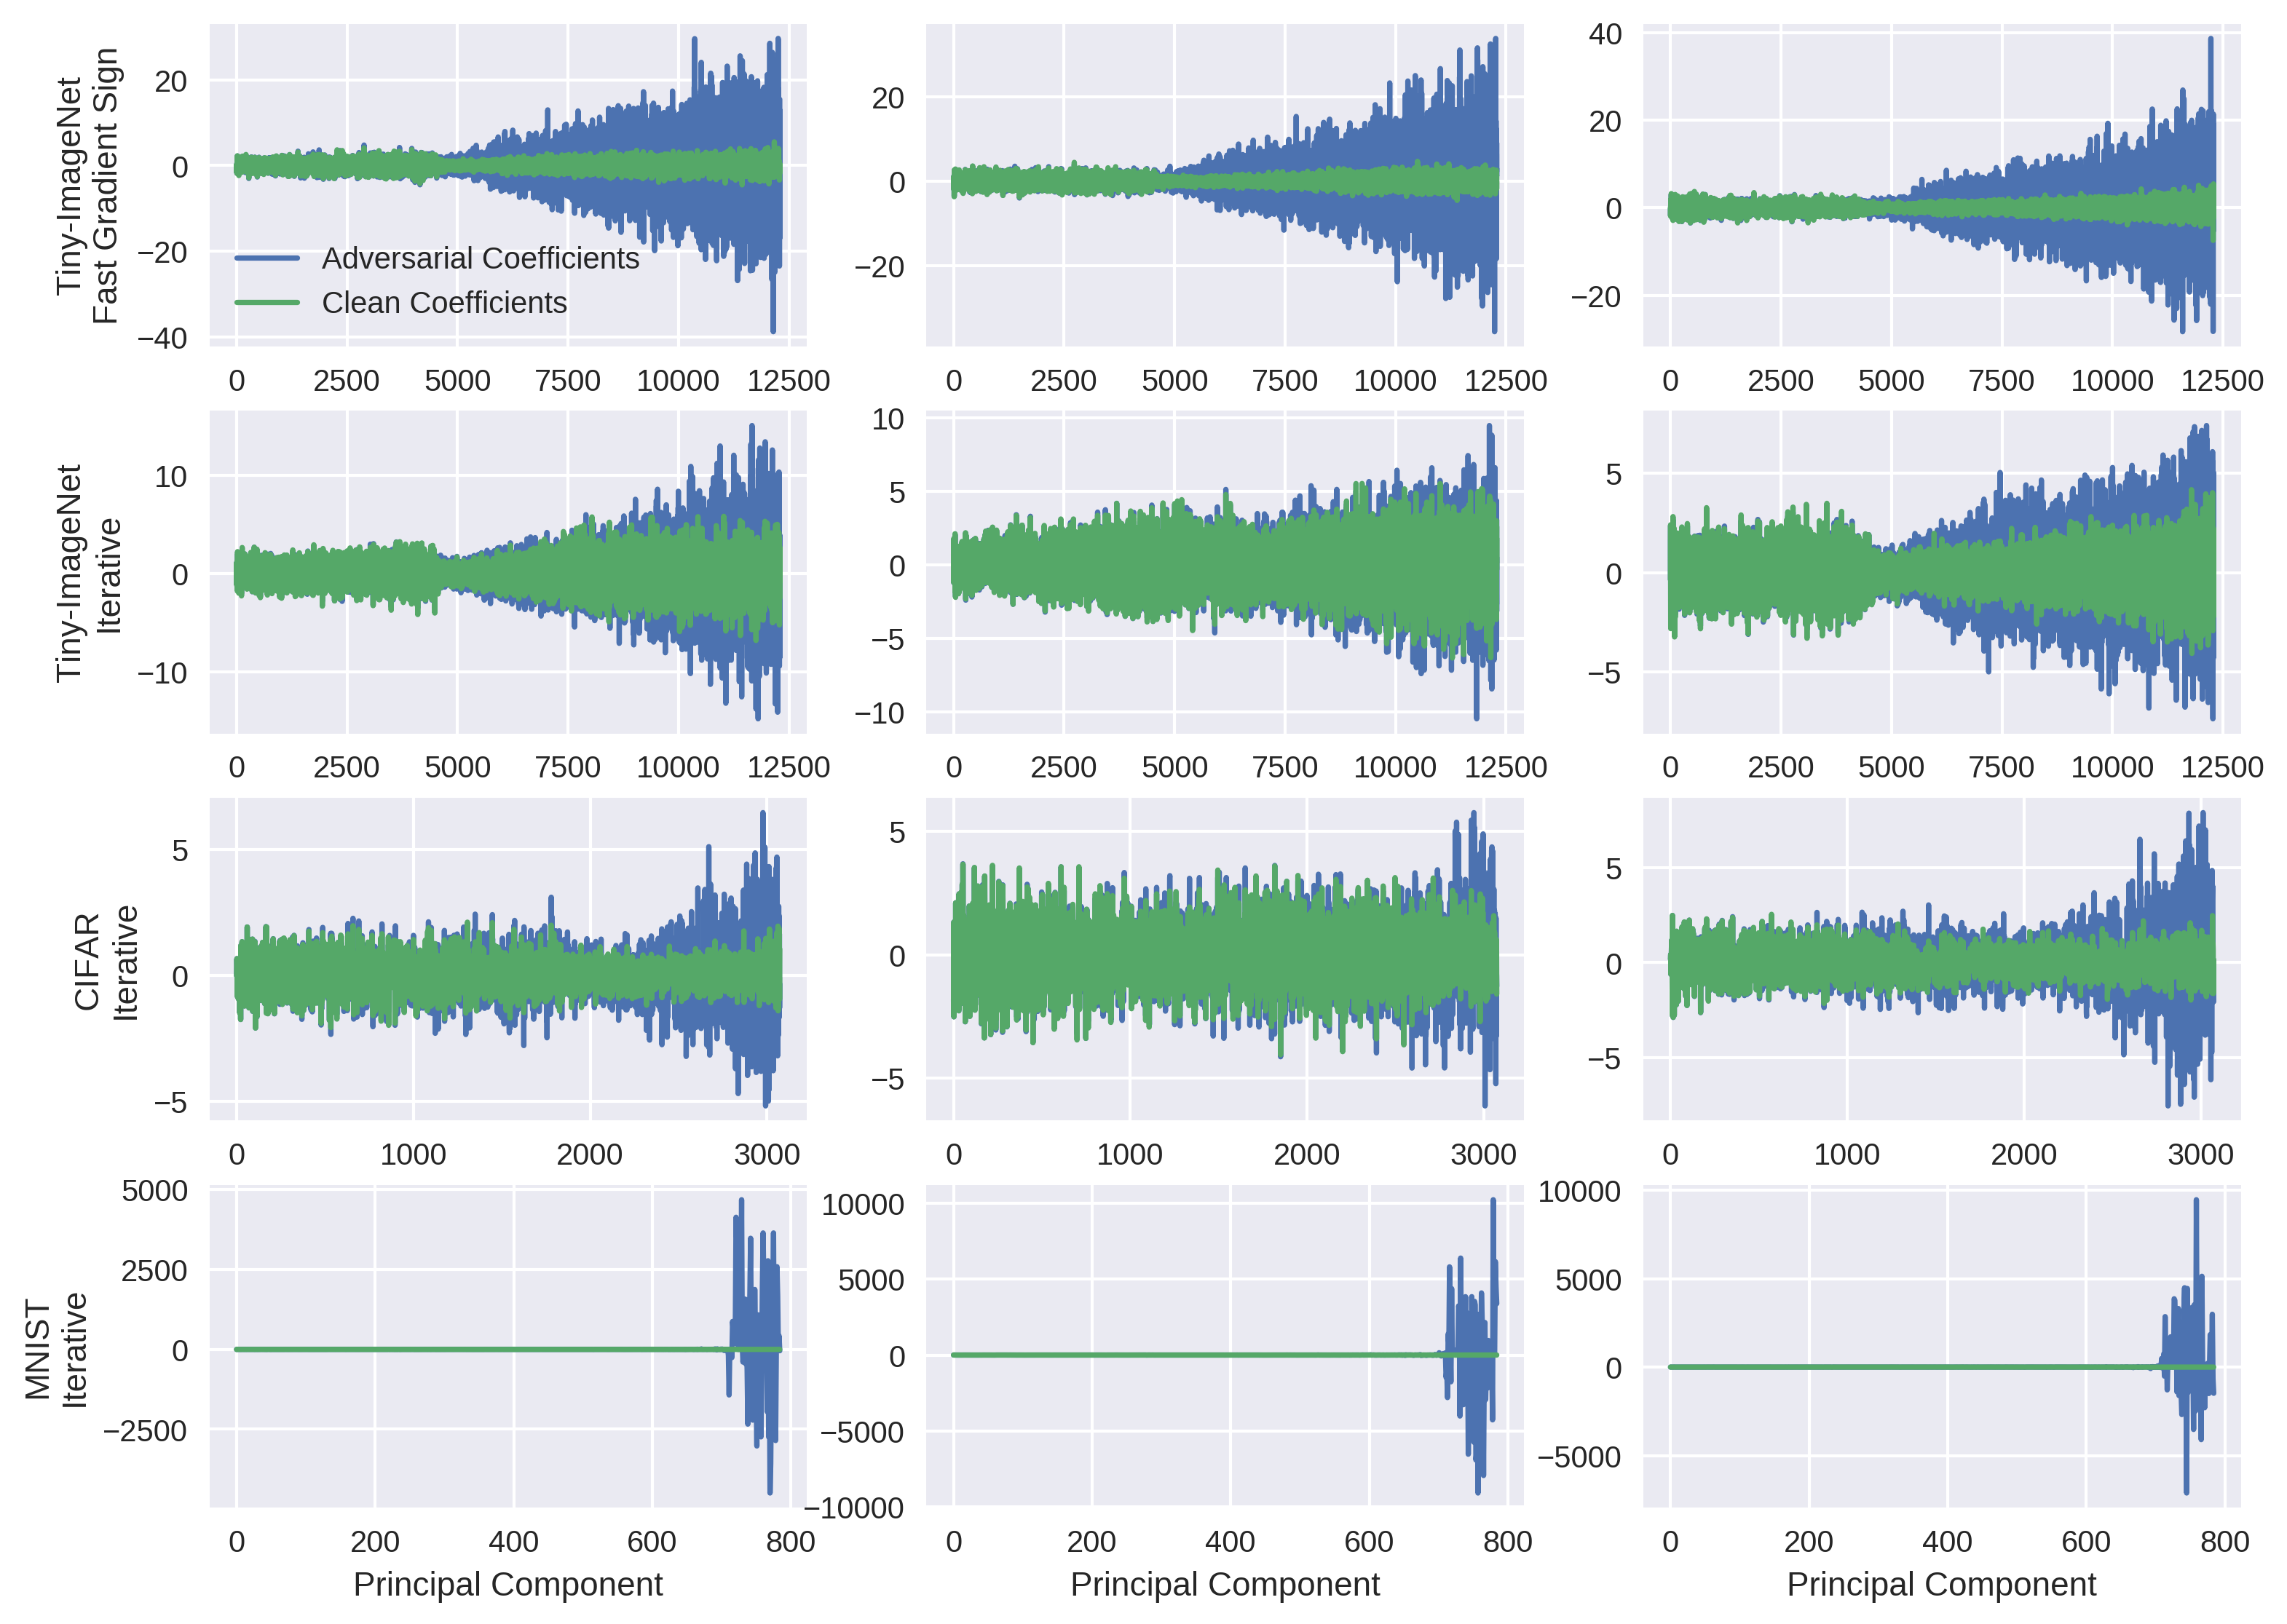

In [95]:
with PdfPages('coefficients.pdf') as pdf:
    rows = ['Tiny-ImageNet\nFast Gradient Sign', 'Tiny-ImageNet\nIterative',
           'CIFAR\nIterative', 'MNIST\nIterative']

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 9), dpi=300)

    fooler_type_number = 0
    for i in range(1,13):
        if fooler_type_number//3 == 0:
            dataset, dataset_keys = tiny_fast_clipped, tiny_fast_clipped_keys
            row_label = rows[0]
        elif fooler_type_number//3 == 1:
            dataset, dataset_keys = tiny_iter_clipped, tiny_iter_clipped_keys
            row_label = rows[1]
        elif fooler_type_number//3 == 2:
            dataset, dataset_keys = cifar_iter, cifar_iter_keys
            row_label = rows[2]
        elif fooler_type_number//3 == 3:
            dataset, dataset_keys = mnist_iter, mnist_iter_keys
            row_label = rows[3]

        k = np.random.choice(dataset_keys)
        if fooler_type_number // 3 != 3:
            image = dataset[k][4][0]
            image_fool = dataset[k][3][0]
        else:
            image = dataset[k][3][0]
            image_fool = dataset[k][2][0]

        plt.subplot(4,3,i)
        if fooler_type_number//3 == 0 or fooler_type_number//3 == 1:
            f = show_tiny_whitened(image_fool, smoother=1e-11).reshape((-1))
            r = show_tiny_whitened(image, smoother=1e-11).reshape((-1))
        elif fooler_type_number//3 == 2:
            img = np.dot(image_fool.reshape((-1))-mean_img_cifar, u_cifar)
            f = img/np.sqrt(s_cifar + 1e-11)
            img = np.dot(image.reshape((-1))-mean_img_cifar, u_cifar)
            r = img/np.sqrt(s_cifar + 1e-11)
        elif fooler_type_number//3 == 3:
            img = np.dot(image_fool-mean_img_mnist, u_mnist)
            f = img/np.sqrt(s_mnist + 1e-11)
            img = np.dot(image-mean_img_mnist, u_mnist)
            r = img/np.sqrt(s_mnist + 1e-11)
        
        plt.plot(np.linspace(0, len(f), len(f)), f, rasterized=True)
        plt.plot(np.linspace(0, len(r), len(r)), r, rasterized=True)

        fooler_type_number += 1    
        if fooler_type_number == 1:
            plt.legend(['Adversarial Coefficients', 'Clean Coefficients'])
        if (fooler_type_number-1) % 3 == 0:
            plt.ylabel(row_label)
        if i == 12 or i == 11 or i == 10:
            plt.xlabel('Principal Component')


    pdf.savefig(fig, bbox_inches='tight', pad_inches=0)

## Adversarial Detection via Variance
### Tiny Imagenet Detection 

In [90]:
import sklearn.metrics as sk

In [91]:
examples = []
labels = []
for k in tiny_fast_clipped_keys:
    examples.append(np.var(show_tiny_whitened(tiny_fast_clipped[k][3][0], smoother=1e-11).reshape((-1))[10000:]))
    labels.append(1)
    examples.append(np.var(show_tiny_whitened(tiny_fast_clipped[k][4][0], smoother=1e-11).reshape((-1))[10000:]))
    labels.append(0)

print('AUROC', sk.roc_auc_score(labels, examples))
print('AUPR', sk.average_precision_score(labels, examples))

dirty = np.array(examples[::2])
clean = np.array(examples[1::2])
print('Fraction of adversarial examples with a variance within 10 stds of the clean variances',
      np.mean(dirty < np.mean(clean) + 10*np.std(clean)))

AUROC 1.0
AUPR 1.0
Fraction of adversarial examples with a variance within 10 stds of the clean variances 0.0


In [92]:
examples = []
labels = []
for k in tiny_iter_clipped_keys:
    examples.append(np.var(show_tiny_whitened(tiny_iter_clipped[k][3][0], smoother=1e-11).reshape((-1))[10000:]))
    labels.append(1)
    examples.append(np.var(show_tiny_whitened(tiny_iter_clipped[k][4][0], smoother=1e-11).reshape((-1))[10000:]))
    labels.append(0)

print('AUROC', sk.roc_auc_score(labels, examples))
print('AUPR', sk.average_precision_score(labels, examples))

AUROC 0.92378328742
AUPR 0.935016300008


### SVHN Adversarial Detection 

In [89]:
examples = []
labels = []
for k in svhn_fast_keys:
    image_fool = svhn_fast[k][3][0].reshape((-1))
    img = np.dot(image_fool-mean_img_svhn, u_svhn)
    f = img/np.sqrt(s_svhn + 1e-11)
    examples.append(np.var(f[2500:]))
    labels.append(1)
    
    image = svhn_fast[k][4][0].reshape((-1))
    img = np.dot(image-mean_img_svhn, u_svhn)
    r = img/np.sqrt(s_svhn + 1e-11)
    examples.append(np.var(r[2500:]))
    labels.append(0)

print('AUROC', sk.roc_auc_score(labels, examples))
print('AUPR', sk.average_precision_score(labels, examples))

dirty = np.array(examples[::2])
clean = np.array(examples[1::2])
print('Fraction of adversarial examples with a variance within 10 stds of the clean variances',
      np.mean(dirty < np.mean(clean) + 10*np.std(clean)))

AUROC 1.0
AUPR 1.0
Fraction of adversarial examples with a variance within 10 stds of the clean variances 0.0


In [87]:
print(np.mean(clean), np.std(clean))
print(np.mean(dirty))

0.937996556177 0.396668655581
191.494675476


In [84]:
examples = []
labels = []
for k in svhn_iter_keys:
    image_fool = svhn_iter[k][3][0].reshape((-1))
    img = np.dot(image_fool-mean_img_svhn, u_svhn)
    f = img/np.sqrt(s_svhn + 1e-11)
    examples.append(np.var(f[2500:]))
    labels.append(1)
    
    image = svhn_iter[k][4][0].reshape((-1))
    img = np.dot(image-mean_img_svhn, u_svhn)
    r = img/np.sqrt(s_svhn + 1e-11)
    examples.append(np.var(r[2500:]))
    labels.append(0)

print('AUROC', sk.roc_auc_score(labels, examples))
print('AUPR', sk.average_precision_score(labels, examples))

AUROC 0.976839098051
AUPR 0.97932481603


### CIFAR10 Adversarial Detection 

In [75]:
examples = []
labels = []
for k in cifar_fast_keys:
    image_fool = cifar_fast[k][3][0].reshape((-1))
    img = np.dot(image_fool-mean_img_cifar, u_cifar)
    f = img/np.sqrt(s_cifar + 1e-11)
    examples.append(np.var(f[2500:]))
    labels.append(1)
    
    image = cifar_fast[k][4][0].reshape((-1))
    img = np.dot(image-mean_img_cifar, u_cifar)
    r = img/np.sqrt(s_cifar + 1e-11)
    examples.append(np.var(r[2500:]))
    labels.append(0)

print('AUROC', sk.roc_auc_score(labels, examples))
print('AUPR', sk.average_precision_score(labels, examples))

dirty = np.array(examples[::2])
clean = np.array(examples[1::2])
print('Fraction of adversarial examples with a variance within 10 stds of the clean variances',
      np.mean(dirty < np.mean(clean) + 10*np.std(clean)))

AUROC 1.0
AUPR 1.0
Fraction of adversarial examples with a variance within 10 stds of the clean variances 0.0


In [76]:
print(np.mean(clean), np.std(clean))
print(np.mean(dirty))

1.45868514158 2.05489693559
72.2227303995


In [77]:
examples = []
labels = []
for k in cifar_iter_keys:
    image_fool = cifar_iter[k][3][0].reshape((-1))
    img = np.dot(image_fool-mean_img_cifar, u_cifar)
    f = img/np.sqrt(s_cifar + 1e-11)
    examples.append(np.var(f[2500:]))
    labels.append(1)
    
    image = cifar_iter[k][4][0].reshape((-1))
    img = np.dot(image-mean_img_cifar, u_cifar)
    r = img/np.sqrt(s_cifar + 1e-11)
    examples.append(np.var(r[2500:]))
    labels.append(0)

print('AUROC', sk.roc_auc_score(labels, examples))
print('AUPR', sk.average_precision_score(labels, examples))

AUROC 0.92765
AUPR 0.912415693201


### MNIST Adversarial Detection 

In [78]:
examples = []
labels = []
for k in mnist_fast_keys:
    image_fool = mnist_fast[k][2][0]
    img = np.dot(image_fool-mean_img_mnist, u_mnist)
    f = img/np.sqrt(s_mnist + 1e-11)
    examples.append(np.var(f[700:]))
    labels.append(1)
    
    image = mnist_fast[k][3][0]
    img = np.dot(image-mean_img_mnist, u_mnist)
    r = img/np.sqrt(s_mnist + 1e-11)
    examples.append(np.var(r[700:]))
    labels.append(0)

print('AUROC', sk.roc_auc_score(labels, examples))
print('AUPR', sk.average_precision_score(labels, examples))

dirty = np.array(examples[::2])
clean = np.array(examples[1::2])
print('Fraction of adversarial examples with a variance within 10 billion stds of the clean variances',
      np.mean(dirty < np.mean(clean) + 10000000000*np.std(clean)))

AUROC 1.0
AUPR 1.0
Fraction of adversarial examples with a variance within 10 billion stds of the clean variances 0.0


In [79]:
examples = []
labels = []
for k in mnist_iter_keys:
    image_fool = mnist_iter[k][2][0]
    img = np.dot(image_fool-mean_img_mnist, u_mnist)
    f = img/np.sqrt(s_mnist + 1e-11)
    examples.append(np.var(f[700:]))
    labels.append(1)

    image = mnist_iter[k][3][0]
    img = np.dot(image-mean_img_mnist, u_mnist)
    r = img/np.sqrt(s_mnist + 1e-11)
    examples.append(np.var(r[700:]))
    labels.append(0)

print('AUROC', sk.roc_auc_score(labels, examples))
print('AUPR', sk.average_precision_score(labels, examples))

AUROC 1.0
AUPR 1.0


### Make Frequency Plots 
####  Frequency Plots for Fast Adversaries 

In [10]:
mnist_advs = [] 
for key in mnist_iter_keys: 
    mnist_advs.append(mnist_iter[key][2][0])
    
mnist_normals = [] 
for key in mnist_iter_keys: 
    mnist_normals.append(mnist_iter[key][3][0])
    
mnist_advs = np.asarray(mnist_advs)
mnist_normals = np.asarray(mnist_normals)

scaled_imgs = mnist_advs.reshape(-1,784) - mean_img_mnist
scaled_imgs = np.dot(scaled_imgs, u_mnist)
f_mnist_advs = scaled_imgs/np.sqrt(s_mnist + 1e-11)

scaled_imgs = mnist_normals.reshape(-1,784) - mean_img_mnist
scaled_imgs = np.dot(scaled_imgs, u_mnist)
f_mnist_normals = scaled_imgs/np.sqrt(s_mnist + 1e-11)

mnist_variances_advs_iter = np.zeros(784)
mnist_variances_normals_iter = np.zeros(784)

for i in range(784):
    mnist_variances_advs_iter[i] = f_mnist_advs.T[i].var()
    mnist_variances_normals_iter[i] = f_mnist_normals.T[i].var()

In [11]:
cifar_advs = [] 
for key in cifar_iter_keys: 
    cifar_advs.append(cifar_iter[key][3][0])
    
cifar_normals = [] 
for key in cifar_iter_keys: 
    cifar_normals.append(cifar_iter[key][4][0])
    
cifar_advs = np.asarray(cifar_advs)
cifar_normals = np.asarray(cifar_normals)

scaled_imgs = cifar_advs.reshape(-1,3072) - mean_img_cifar
scaled_imgs = np.dot(scaled_imgs, u_cifar)
f_cifar_advs = scaled_imgs/np.sqrt(s_cifar + 1e-11)

scaled_imgs = cifar_normals.reshape(-1,3072) - mean_img_cifar
scaled_imgs = np.dot(scaled_imgs, u_cifar)
f_cifar_normals = scaled_imgs/np.sqrt(s_cifar + 1e-11)

cifar_variances_advs = np.zeros(3072)
cifar_variances_normals = np.zeros(3072)

for i in range(3072):
    cifar_variances_advs[i] = f_cifar_advs.T[i].var()
    cifar_variances_normals[i] = f_cifar_normals.T[i].var()

In [12]:
svhn_advs = [] 
for key in svhn_iter_keys: 
    svhn_advs.append(svhn_iter[key][3][0])
    
svhn_normals = [] 
for key in svhn_iter_keys: 
    svhn_normals.append(svhn_iter[key][4][0])
    
svhn_advs = np.asarray(svhn_advs)
svhn_normals = np.asarray(svhn_normals)

scaled_imgs = svhn_advs.reshape(-1,3072) - mean_img_svhn
scaled_imgs = np.dot(scaled_imgs, u_svhn)
f_svhn_advs = scaled_imgs/np.sqrt(s_svhn + 1e-11)

scaled_imgs = svhn_normals.reshape(-1,3072) - mean_img_svhn
scaled_imgs = np.dot(scaled_imgs, u_svhn)
f_svhn_normals = scaled_imgs/np.sqrt(s_svhn + 1e-11)

svhn_variances_advs = np.zeros(3072)
svhn_variances_normals = np.zeros(3072)

for i in range(3072):
    svhn_variances_advs[i] = f_svhn_advs.T[i].var()
    svhn_variances_normals[i] = f_svhn_normals.T[i].var()

In [68]:
tiny_advs = [] 
for key in tiny_iter_keys: 
    tiny_advs.append(tiny_iter[key][3][0])
    
tiny_normals = [] 
for key in tiny_iter_keys: 
    tiny_normals.append(tiny_iter[key][4][0])
    
tiny_advs = np.asarray(tiny_advs)
tiny_normals = np.asarray(tiny_normals)

scaled_imgs = tiny_advs.reshape(-1,12288) - mean_img_tiny
scaled_imgs = np.dot(scaled_imgs, u_tiny)
f_tiny_advs = scaled_imgs/np.sqrt(s_tiny + 1e-11)

scaled_imgs = tiny_normals.reshape(-1,12288) - mean_img_tiny
scaled_imgs = np.dot(scaled_imgs, u_tiny)
f_tiny_normals = scaled_imgs/np.sqrt(s_tiny + 1e-11)

tiny_variances_advs = np.zeros(12288)
tiny_variances_normals = np.zeros(12288)

for i in range(12288):
    tiny_variances_advs[i] = f_tiny_advs.T[i].var()
    tiny_variances_normals[i] = f_tiny_normals.T[i].var()

In [19]:
sns.set()
sns.set_color_codes('pastel')

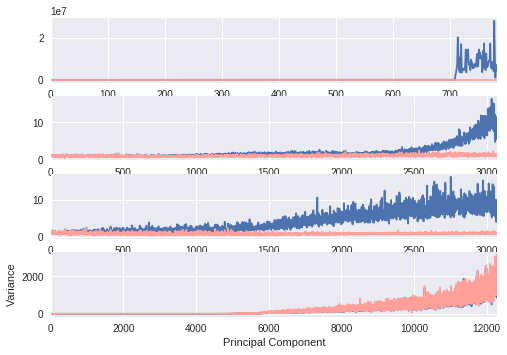

In [110]:

for i in range(1,5):

    plt.subplot(4,1,i)
    if i == 1: 
        sns.tsplot(mnist_variances_advs)
        sns.tsplot(mnist_variances_normals, color = 'r')
    if i == 2:   
        sns.tsplot(cifar_variances_advs)
        sns.tsplot(cifar_variances_normals, color = 'r')

    if i == 3: 
        sns.tsplot(svhn_variances_advs)
        sns.tsplot(svhn_variances_normals, color = 'r')
    
    if i == 4: 
        sns.tsplot(tiny_variances_advs)
        sns.tsplot(tiny_variances_normals, color = 'r')

plt.ylabel("Variance")
plt.xlabel('Principal Component')

#### Frequency Plots for Fast Adversaries 

In [103]:
mnist_advs = [] 
for key in mnist_fast_keys: 
    mnist_advs.append(mnist_fast[key][2][0])
    
mnist_normals = [] 
for key in mnist_fast_keys: 
    mnist_normals.append(mnist_fast[key][3][0])
    
mnist_advs = np.asarray(mnist_advs)
mnist_normals = np.asarray(mnist_normals)

scaled_imgs = mnist_advs.reshape(-1,784) - mean_img_mnist
scaled_imgs = np.dot(scaled_imgs, u_mnist)
f_mnist_advs = scaled_imgs/np.sqrt(s_mnist + 1e-11)

scaled_imgs = mnist_normals.reshape(-1,784) - mean_img_mnist
scaled_imgs = np.dot(scaled_imgs, u_mnist)
f_mnist_normals = scaled_imgs/np.sqrt(s_mnist + 1e-11)

mnist_variances_advs_fast = np.zeros(784)
mnist_variances_normals_fast = np.zeros(784)

for i in range(784):
    mnist_variances_advs_fast[i] = f_mnist_advs.T[i].var()
    mnist_variances_normals_fast[i] = f_mnist_normals.T[i].var()

In [104]:
cifar_advs = [] 
for key in cifar_fast_keys: 
    cifar_advs.append(cifar_fast[key][3][0])
    
cifar_normals = [] 
for key in cifar_fast_keys: 
    cifar_normals.append(cifar_fast[key][4][0])
    
cifar_advs = np.asarray(cifar_advs)
cifar_normals = np.asarray(cifar_normals)

scaled_imgs = cifar_advs.reshape(-1,3072) - mean_img_cifar
scaled_imgs = np.dot(scaled_imgs, u_cifar)
f_cifar_advs = scaled_imgs/np.sqrt(s_cifar + 1e-11)

scaled_imgs = cifar_normals.reshape(-1,3072) - mean_img_cifar
scaled_imgs = np.dot(scaled_imgs, u_cifar)
f_cifar_normals = scaled_imgs/np.sqrt(s_cifar + 1e-11)

cifar_variances_advs_fast = np.zeros(3072)
cifar_variances_normals_fast = np.zeros(3072)

for i in range(3072):
    cifar_variances_advs_fast[i] = f_cifar_advs.T[i].var()
    cifar_variances_normals_fast[i] = f_cifar_normals.T[i].var()

In [105]:
svhn_advs = [] 
for key in svhn_fast_keys: 
    svhn_advs.append(svhn_fast[key][3][0])
    
svhn_normals = [] 
for key in svhn_fast_keys: 
    svhn_normals.append(svhn_fast[key][4][0])
    
svhn_advs = np.asarray(svhn_advs)
svhn_normals = np.asarray(svhn_normals)

scaled_imgs = svhn_advs.reshape(-1,3072) - mean_img_svhn
scaled_imgs = np.dot(scaled_imgs, u_svhn)
f_svhn_advs = scaled_imgs/np.sqrt(s_svhn + 1e-11)

scaled_imgs = svhn_normals.reshape(-1,3072) - mean_img_svhn
scaled_imgs = np.dot(scaled_imgs, u_svhn)
f_svhn_normals = scaled_imgs/np.sqrt(s_svhn + 1e-11)

svhn_variances_advs_fast = np.zeros(3072)
svhn_variances_normals_fast = np.zeros(3072)

for i in range(3072):
    svhn_variances_advs_fast[i] = f_svhn_advs.T[i].var()
    svhn_variances_normals_fast[i] = f_svhn_normals.T[i].var()

In [107]:
tiny_advs = [] 
for key in tiny_fast_keys: 
    tiny_advs.append(tiny_fast[key][3][0])
    
tiny_normals = [] 
for key in tiny_fast_keys: 
    tiny_normals.append(tiny_fast[key][4][0])
    
tiny_advs = np.asarray(tiny_advs)
tiny_normals = np.asarray(tiny_normals)

scaled_imgs = tiny_advs.reshape(-1,12288) - mean_img_tiny
scaled_imgs = np.dot(scaled_imgs, u_tiny)
f_tiny_advs = scaled_imgs/np.sqrt(s_tiny + 1e-11)

scaled_imgs = tiny_normals.reshape(-1,12288) - mean_img_tiny
scaled_imgs = np.dot(scaled_imgs, u_tiny)
f_tiny_normals = scaled_imgs/np.sqrt(s_tiny + 1e-11)

tiny_variances_advs_fast = np.zeros(12288)
tiny_variances_normals_fast = np.zeros(12288)

for i in range(12288):
    tiny_variances_advs_fast[i] = f_tiny_advs.T[i].var()
    tiny_variances_normals_fast[i] = f_tiny_normals.T[i].var()

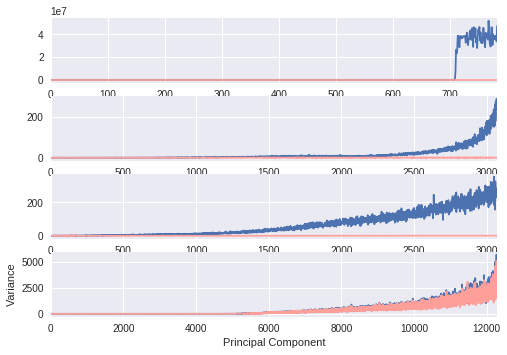

In [109]:
for i in range(1,5):

    plt.subplot(4,1,i)
    if i == 1: 
        sns.tsplot(mnist_variances_advs_fast)
        sns.tsplot(mnist_variances_normals_fast, color = 'r')
    if i == 2:   
        sns.tsplot(cifar_variances_advs_fast)
        sns.tsplot(cifar_variances_normals_fast, color = 'r')

    if i == 3: 
        sns.tsplot(svhn_variances_advs_fast)
        sns.tsplot(svhn_variances_normals_fast, color = 'r')
    
    if i == 4: 
        sns.tsplot(tiny_variances_advs_fast)
        sns.tsplot(tiny_variances_normals_fast, color = 'r')

plt.ylabel("Variance")
plt.xlabel('Principal Component')